<a href="https://colab.research.google.com/github/Maneekul/Intern/blob/main/EffNet_M_10_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  import tarfile
  import os
  import itertools
  import matplotlib.pylab as plt
  import numpy as np
  import tensorflow as tf
  import tensorflow_hub as hub
  import csv
  import time
  import torch
  import json
  from random import randint
  from pathlib import Path
  from PIL import Image
  import PIL.Image
  from scipy.io import loadmat
  import pandas as pd
  from torch import nn
  from torch import optim
  import torch.nn.functional as F
  from torchvision import datasets, transforms, models
  import torchvision.models as models
  from matplotlib.ticker import FormatStrFormatter
  from google.colab.patches import cv2_imshow
  from google.colab import drive
  import matplotlib.image as mpimg
  from matplotlib.pyplot import imshow
  from IPython.display import Image
%matplotlib inline


In [ ]:
#Download full training data (~935 MB)
!wget --no-check-certificate \
    http://ai.stanford.edu/~jkrause/car196/cars_train.tgz \
    -O /tmp/cars_train.tgz #downloaded directory
#extract training data to /tmp/train/a
train_tar = tarfile.open('/tmp/cars_train.tgz')
train_tar.extractall('/tmp/train') # specify which folder to extract to
train_tar.close()
#directory looks like /tmp/train/cars_train/

--2023-04-21 04:33:03--  http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘/tmp/cars_train.tgz’

/tmp/cars_train.tgz 100%[===================>] 933.90M  97.1MB/s    in 10s     

2023-04-21 04:33:13 (92.0 MB/s) - ‘/tmp/cars_train.tgz’ saved [979269282/979269282]



In [ ]:
#Download full testing data (~933MB)
!wget --no-check-certificate \
    http://ai.stanford.edu/~jkrause/car196/cars_test.tgz \
    -O /tmp/cars_test.tgz
     #downloaded directory
#extract testing data to tmp/test/
test_tar = tarfile.open('/tmp/cars_test.tgz')
test_tar.extractall('/tmp/test') # specify which folder to extract to
test_tar.close()
#directory looks like /tmp/test/cars_test/

--2023-04-21 04:33:24--  http://ai.stanford.edu/~jkrause/car196/cars_test.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘/tmp/cars_test.tgz’

/tmp/cars_test.tgz  100%[===================>] 932.07M  11.9MB/s    in 73s     

2023-04-21 04:34:37 (12.7 MB/s) - ‘/tmp/cars_test.tgz’ saved [977350468/977350468]



In [ ]:
#Download labels (~0.3MB)
!wget --no-check-certificate \
    https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz \
    -O /tmp/car_devkit.tgz
Path("/tmp/annos").mkdir(parents=True, exist_ok=True)

drive.mount('/content/drive')

##!wget --no-check-certificate \
##    /content/drive/MyDrive/csv_label/anno_test.csv \
##    -O /tmp/annos/anno_test.csv

data_test_cars = pd.read_csv('/content/drive/MyDrive/csv_label/anno_test.csv')
data_test_cars.head()

#extract labels to /tmp/labels/
label_tar = tarfile.open('/tmp/car_devkit.tgz')
label_tar.extractall('/tmp/labels') # specify which folder to extract to
label_tar.close()



--2023-04-21 04:34:45--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘/tmp/car_devkit.tgz’

/tmp/car_devkit.tgz 100%[===================>] 323.20K  --.-KB/s    in 0.1s    

2023-04-21 04:34:45 (2.16 MB/s) - ‘/tmp/car_devkit.tgz’ saved [330960/330960]

Mounted at /content/drive


In [ ]:
#Classes are assigned numerical value of 1-196, each
#mapping to a string. Data from cars_meta matlab file
#This applies to all data.
meta = loadmat('/tmp/labels/devkit/cars_meta.mat')
meta.keys()
type(meta['class_names']),meta['class_names'].shape
[item.flat[0] for item in meta['class_names'][0][0]]
classes = [[row.flat[0] for row in line] for line in meta['class_names'][0]]
classDict = {}
classCount = 1
for c in classes:
    classDict.update({classCount:c[0]})
    classCount = classCount + 1
term = 0
for num, model in classDict.items():
    #print('Class #', num,'Model String:', model)
    term = term + 1

print('...')

...


In [ ]:
#LABELS FOR TRAINING DATA
#contains bbox, class, and filename
labelfile = loadmat('/tmp/labels/devkit/cars_train_annos.mat')
labelfile.keys()
type(labelfile['annotations']),labelfile['annotations'].shape
type(labelfile['annotations'][0][0]),labelfile['annotations'][0][0].shape
labelfile['annotations'][0][0]['bbox_x1'], labelfile['annotations'][0][0]['fname']
[item.flat[0] for item in labelfile['annotations'][0][0]]
"""
The following variable 'trainLabels' contains a list of labels for
every test image the format of each element is as follows:
### bbox_x1, bbox_y1, bbox_x2, bbox_y2, class, filename
"""
trainLabels = [[row.flat[0] for row in line] for line in labelfile['annotations'][0]]
#Outputting the table for readibility with pandas
columns = ['boundingbox_x1', 'boundingbox_y1', 'boundingbox_x2', 'boundingbox_y2', 'class', 'fname']
view = pd.DataFrame(trainLabels, columns=columns)
view.head()

,boundingbox_x1,boundingbox_y1,boundingbox_x2,boundingbox_y2,class,fname
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,134,00004.jpg
4,14,36,133,99,106,00005.jpg


In [ ]:
#LABELS FOR TESTING DATA
#Contains bbox and filename
lf = loadmat('/tmp/labels/devkit/cars_test_annos.mat')
lf.keys()
type(lf['annotations']),lf['annotations'].shape
type(lf['annotations'][0][0]),lf['annotations'][0][0].shape
lf['annotations'][0][0]['bbox_x1'], lf['annotations'][0][0]['fname']
[item.flat[0] for item in lf['annotations'][0][0]]
"""
The following variable 'testLabels' contains a list of labels for
every test image the format of each element is as follows:
### bbox_x1, bbox_y1, bbox_x2, bbox_y2, filename
there is no class name in this set of labels
"""
testLabels = [[row.flat[0] for row in line] for line in lf['annotations'][0]]

#Test labels class and fname
with open('/content/drive/MyDrive/csv_label/anno_test.csv') as csv_file:
    read = csv.reader(csv_file, delimiter=',')
    testDict = {}
    classCount = 1
    for row in read:
        testDict.update({row[0]:row[5]})
        classCount = classCount + 1
    print(len(testDict), 'processed')

8041 processed


In [ ]:
#What labels look like for Training vs Testing after processing
print("Train Labels")
print("...")
for i in range(len(trainLabels) - 4, len(trainLabels)):
    print(trainLabels[i])
print("\nTest Labels")
print("...")
for i in range(len(testLabels) - 4, len(testLabels)):
    print(testLabels[i])


Train Labels
...
[138, 150, 706, 523, 196, '08141.jpg']
[26, 246, 660, 449, 163, '08142.jpg']
[78, 526, 1489, 908, 112, '08143.jpg']
[20, 240, 862, 677, 17, '08144.jpg']

Test Labels
...
[23, 18, 640, 459, '08038.jpg']
[33, 27, 602, 252, '08039.jpg']
[33, 142, 521, 376, '08040.jpg']
[77, 73, 506, 380, '08041.jpg']


In [ ]:
"""
Preprocess Training Images
Gets all training images and crops by bounding box, saves to a new directory
The directory housing training image has subdirectories named by class name
with each corresponding image in the corresponding folder
Saves ~7% of images for validation
"""
print(len(trainLabels), "images to process.")
Path("/tmp/processedTrain").mkdir(parents=True, exist_ok=True)
Path("/tmp/processedValidation").mkdir(parents=True, exist_ok=True)
count = 1
for l in trainLabels:
    print('Processing image', count, 'of', len(trainLabels))
    #bbox
    x1 = l[0]
    y1 = l[1]
    x2 = l[2]
    y2 = l[3]
    class_num = l[4]
    filename = l[5]
    address = "/tmp/train/cars_train/" + filename
    classAppend = classDict.get(class_num) + '/'
    if count < 7000:
        saveDir = "/tmp/processedTrain/" + classAppend
    else:
        saveDir = "/tmp/processedValidation/" + classAppend
    im = PIL.Image.open(address)
    region = im.crop((x1, y1, x2, y2))
    Path(saveDir).mkdir(parents=True, exist_ok=True)
    saveAddress = saveDir + filename
    region.save(saveAddress)
    print('Saved', saveAddress)
    count = count + 1
print("------------------------")
print("Training images preprocessing complete.")

Streaming output truncated to the last 5000 lines.
Processing image 5646 of 8144
Saved /tmp/processedTrain/Chevrolet HHR SS 2010/05646.jpg
Processing image 5647 of 8144
Saved /tmp/processedTrain/Audi TT RS Coupe 2012/05647.jpg
Processing image 5648 of 8144
Saved /tmp/processedTrain/Bentley Arnage Sedan 2009/05648.jpg
Processing image 5649 of 8144
Saved /tmp/processedTrain/Ford F-150 Regular Cab 2007/05649.jpg
Processing image 5650 of 8144
Saved /tmp/processedTrain/BMW 3 Series Sedan 2012/05650.jpg
Processing image 5651 of 8144
Saved /tmp/processedTrain/Fisker Karma Sedan 2012/05651.jpg
Processing image 5652 of 8144
Saved /tmp/processedTrain/MINI Cooper Roadster Convertible 2012/05652.jpg
Processing image 5653 of 8144
Saved /tmp/processedTrain/Dodge Dakota Crew Cab 2010/05653.jpg
Processing image 5654 of 8144
Saved /tmp/processedTrain/BMW 1 Series Coupe 2012/05654.jpg
Processing image 5655 of 8144
Saved /tmp/processedTrain/Ford Freestar Minivan 2007/05655.jpg
Processing image 5656 of 81

In [ ]:
"""
Preprocess Testing Images
Gets all training images and crops by bounding box, saves to a new directory
"""
print(len(testLabels), "images to process.")
Path("/tmp/processedTest").mkdir(parents=True, exist_ok=True)
Path("/tmp/boundedTest").mkdir(parents=True, exist_ok=True)
count = 1
for l in testLabels:
    print('Processing image', count, 'of', len(testLabels))
    x1 = l[0]
    y1 = l[1]
    x2 = l[2]
    y2 = l[3]
    filename = l[4]
    c_num = testDict.get(filename)
    classAppend = classDict.get(int(c_num)) + '/'
    address = "/tmp/test/cars_test/" + filename
    saveDir = "/tmp/processedTest/" + classAppend
    im = PIL.Image.open(address)
    region = im.crop((x1, y1, x2, y2))
    Path(saveDir).mkdir(parents=True, exist_ok=True)
    saveAddress = saveDir + filename
    saveAddress2 = "/tmp/boundedTest/" + filename
    region.save(saveAddress2)
    print('Saved', saveAddress2)
    region.save(saveAddress)
    print('Saved', saveAddress)
    count = count + 1
print("------------------------")
print("Testing images preprocessing complete.")

Streaming output truncated to the last 5000 lines.
Processing image 6376 of 8041
Saved /tmp/boundedTest/06376.jpg
Saved /tmp/processedTest/Rolls-Royce Phantom Sedan 2012/06376.jpg
Processing image 6377 of 8041
Saved /tmp/boundedTest/06377.jpg
Saved /tmp/processedTest/Dodge Charger SRT-8 2009/06377.jpg
Processing image 6378 of 8041
Saved /tmp/boundedTest/06378.jpg
Saved /tmp/processedTest/Dodge Caravan Minivan 1997/06378.jpg
Processing image 6379 of 8041
Saved /tmp/boundedTest/06379.jpg
Saved /tmp/processedTest/Audi TT RS Coupe 2012/06379.jpg
Processing image 6380 of 8041
Saved /tmp/boundedTest/06380.jpg
Saved /tmp/processedTest/Nissan 240SX Coupe 1998/06380.jpg
Processing image 6381 of 8041
Saved /tmp/boundedTest/06381.jpg
Saved /tmp/processedTest/Hyundai Sonata Sedan 2012/06381.jpg
Processing image 6382 of 8041
Saved /tmp/boundedTest/06382.jpg
Saved /tmp/processedTest/Bentley Arnage Sedan 2009/06382.jpg
Processing image 6383 of 8041
Saved /tmp/boundedTest/06383.jpg
Saved /tmp/processe

In [ ]:
print('TF version:', tf.__version__)
print('Hub version:', hub.__version__)
print('Phsical devices:', tf.config.list_physical_devices())

def get_hub_url_and_isize(model_name, ckpt_type, hub_type):
  if ckpt_type == '1k':
    ckpt_type = ''  # json doesn't support empty string
  else:
    ckpt_type = '-' + ckpt_type  # add '-' as prefix

  hub_url_map = {
    'efficientnetv2-b0': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0/{hub_type}',
    'efficientnetv2-b1': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b1/{hub_type}',
    'efficientnetv2-b2': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b2/{hub_type}',
    'efficientnetv2-b3': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b3/{hub_type}',
    'efficientnetv2-s':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s/{hub_type}',
    'efficientnetv2-m':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m/{hub_type}',
    'efficientnetv2-l':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l/{hub_type}',

    'efficientnetv2-b0-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0-21k/{hub_type}',
    'efficientnetv2-b1-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b1-21k/{hub_type}',
    'efficientnetv2-b2-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b2-21k/{hub_type}',
    'efficientnetv2-b3-21k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b3-21k/{hub_type}',
    'efficientnetv2-s-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s-21k/{hub_type}',
    'efficientnetv2-m-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m-21k/{hub_type}',
    'efficientnetv2-l-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l-21k/{hub_type}',
    'efficientnetv2-xl-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-xl-21k/{hub_type}',

    'efficientnetv2-b0-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0-21k-ft1k/{hub_type}',
    'efficientnetv2-b1-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b1-21k-ft1k/{hub_type}',
    'efficientnetv2-b2-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b2-21k-ft1k/{hub_type}',
    'efficientnetv2-b3-21k-ft1k': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b3-21k-ft1k/{hub_type}',
    'efficientnetv2-s-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s-21k-ft1k/{hub_type}',
    'efficientnetv2-m-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m-21k-ft1k/{hub_type}',
    'efficientnetv2-l-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l-21k-ft1k/{hub_type}',
    'efficientnetv2-xl-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-xl-21k-ft1k/{hub_type}',

    # efficientnetv1
    'efficientnet_b0': f'https://tfhub.dev/tensorflow/efficientnet/b0/{hub_type}/1',
    'efficientnet_b1': f'https://tfhub.dev/tensorflow/efficientnet/b1/{hub_type}/1',
    'efficientnet_b2': f'https://tfhub.dev/tensorflow/efficientnet/b2/{hub_type}/1',
    'efficientnet_b3': f'https://tfhub.dev/tensorflow/efficientnet/b3/{hub_type}/1',
    'efficientnet_b4': f'https://tfhub.dev/tensorflow/efficientnet/b4/{hub_type}/1',
    'efficientnet_b5': f'https://tfhub.dev/tensorflow/efficientnet/b5/{hub_type}/1',
    'efficientnet_b6': f'https://tfhub.dev/tensorflow/efficientnet/b6/{hub_type}/1',
    'efficientnet_b7': f'https://tfhub.dev/tensorflow/efficientnet/b7/{hub_type}/1',
  }

  image_size_map = {
    'efficientnetv2-b0': 224,
    'efficientnetv2-b1': 240,
    'efficientnetv2-b2': 260,
    'efficientnetv2-b3': 300,
    'efficientnetv2-s':  384,
    'efficientnetv2-m':  480,
    'efficientnetv2-l':  480,
    'efficientnetv2-xl':  512,

    'efficientnet_b0': 224,
    'efficientnet_b1': 240,
    'efficientnet_b2': 260,
    'efficientnet_b3': 300,
    'efficientnet_b4': 380,
    'efficientnet_b5': 456,
    'efficientnet_b6': 528,
    'efficientnet_b7': 600,
  }

  hub_url = hub_url_map.get(model_name + ckpt_type)
  image_size = image_size_map.get(model_name, 224)
  return hub_url, image_size


def get_imagenet_labels(filename):
  labels = []
  with open(filename, 'r') as f:
    for line in f:
      labels.append(line.split('\t')[1][:-1])  # split and remove line break.
  return labels


TF version: 2.12.0
Hub version: 0.13.0
Phsical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Build your model
import tensorflow_hub as hub
model_name = 'efficientnetv2-m' #@param {type:'string'}
ckpt_type = '1k'   # @param ['21k', '21k-ft1k', '1k']
hub_type = 'classification' # @param ['feature-vector'] classification
batch_size =  4 #@param {type:"integer"}
hub_url, image_size = get_hub_url_and_isize(model_name, ckpt_type, hub_type)

# ==> efficientnetv2-b0,b1,b2,b3 can use batch_size = 32
# ==> efficientnetv2-s can use batch_size = 16
# ==> efficientnetv2-m can use batch_size =  4



In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=(image_size, image_size),
                       batch_size=batch_size,
                       interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    '/tmp/processedTrain', subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    '/tmp/processedTrain', subset="training", shuffle=True, **dataflow_kwargs)



Found 1319 images belonging to 196 classes.
Found 5680 images belonging to 196 classes.


In [ ]:
# whether to finetune the whole model or just the top layer.
do_fine_tuning = True #@param {type:"boolean"}
num_epochs = 10 #@param {type:"integer"}

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=[image_size, image_size, 3]),
    hub.KerasLayer(hub_url, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None, image_size, image_size, 3))
model.summary()

model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=num_epochs, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              54431388  
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 196)               196196    
                                                                 
Total params: 54,627,584
Trainable params: 54,335,552
Non-trainable params: 292,032
_________________________________________________________________
Epoch 1/10
1420/1420 [==============================] - 817s 513ms/step - loss: 3.9075 - accuracy: 0.2364 - val_loss: 2.2864 - val_accuracy: 0.6315
Epoch 2/10
1420/1420 [==============================] - 688s 485ms/step - loss: 1.9622 - accuracy: 0.7197 - val_loss: 1.7548 - val_accuracy: 0.8153
Epoch 

In [ ]:
data_test_cars = pd.read_csv('/content/drive/MyDrive/csv_label/anno_test.csv', header=None, names=['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])
print(data_test_cars.head())
list_array = data_test_cars.values.tolist()
print('list_array', list_array)

#print(testLabels)
#print(data_test_cars)

#print(list_array [0][0])
#print(testLabels[0][4])

#print(list_array[4][5])

    filename  class  xmin  ymin  xmax  ymax
0  00001.jpg     30    52   246   147   181
1  00002.jpg    100    19   576   203   103
2  00003.jpg     51   105   968   659   145
3  00004.jpg     67    84   581   407   187
4  00005.jpg    140   151   593   339   185
list_array [['00001.jpg', 30, 52, 246, 147, 181], ['00002.jpg', 100, 19, 576, 203, 103], ['00003.jpg', 51, 105, 968, 659, 145], ['00004.jpg', 67, 84, 581, 407, 187], ['00005.jpg', 140, 151, 593, 339, 185], ['00006.jpg', 20, 77, 420, 301, 78], ['00007.jpg', 249, 166, 2324, 1459, 118], ['00008.jpg', 119, 215, 1153, 719, 165], ['00009.jpg', 1, 7, 275, 183, 32], ['00010.jpg', 28, 55, 241, 177, 60], ['00011.jpg', 30, 20, 438, 253, 49], ['00012.jpg', 14, 21, 242, 156, 108], ['00013.jpg', 1, 42, 495, 313, 116], ['00014.jpg', 8, 63, 395, 287, 135], ['00015.jpg', 50, 103, 569, 403, 83], ['00016.jpg', 80, 116, 359, 250, 51], ['00017.jpg', 9, 48, 630, 361, 154], ['00018.jpg', 113, 66, 554, 369, 33], ['00019.jpg', 82, 70, 277, 168, 22], [

01810.jpg
/tmp/boundedTest/01810.jpg
class number = 173
True label = ['Porsche Panamera Sedan 2012']




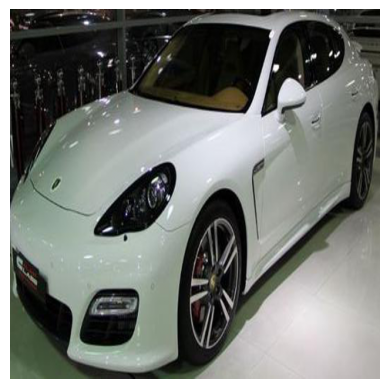

1/1 [==============================] - 3s 3s/step
Top 5 predictions 
class number = 173
True label = ['Porsche Panamera Sedan 2012']
1st prediction ==> Porsche Panamera Sedan 2012


 1) ==>  Porsche Panamera Sedan 2012  <==  with probability == 7.33
 2) ==>  Hyundai Veloster Hatchback 2012  <==  with probability == 3.02
 3) ==>  Rolls-Royce Ghost Sedan 2012  <==  with probability == 2.90
 4) ==>  Hyundai Azera Sedan 2012  <==  with probability == 2.79
 5) ==>  Ford E-Series Wagon Van 2012  <==  with probability == 2.39


In [ ]:
def get_class_string_from_index(index):
    for class_string, class_index in valid_generator.class_indices.items():
        if class_index == index:
            return class_string

random_test_image = str(str(randint(1, len(testLabels))).zfill(5)) + '.jpg'
print(random_test_image)
image_to_classify = "/tmp/boundedTest/" + random_test_image
print(image_to_classify)

i=0
for i in range(len(list_array)):
    if list_array[i][0] == random_test_image:
        x = list_array[i][5]
        print('class number =', x)
        true_label = classes[x-1]
        print('True label =', true_label)
print('\n')

# Display
gimg = PIL.Image.open(image_to_classify)
gimg = gimg.resize((480, 480))  # adapt resize using image_size_map
gimg = np.array(gimg) / 255.0
plt.imshow(gimg)
plt.axis('off')
plt.show()


top_k = 5
prediction_scores = model.predict(np.expand_dims(gimg, axis=0))
predicted_indices = (-prediction_scores[0]).argsort()[:top_k]
#print(predicted_indices)
print("Top {} predictions ".format(top_k))
for i, index in enumerate(predicted_indices):
    predicted_label = get_class_string_from_index(index)
    if i == 0:
        print('class number =', x)
        print('True label =', true_label)
        print("1st prediction ==> " + predicted_label)
        print('\n')
        if prediction_scores[0][index] >= 10.00 :
           print("NOPE")

    print(" {}) ==>  {}  <==  with probability == {:.2f}".format(i+1, predicted_label, prediction_scores[0][index]))


/tmp/boundedTest/02895.jpg




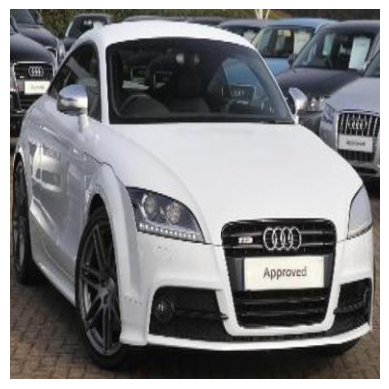

1/1 [==============================] - 3s 3s/step
Top 5 predictions 
1st prediction ==> Audi TT Hatchback 2011


 1) ==>  Audi TT Hatchback 2011  <==  with probability == 9.73
 2) ==>  Audi TTS Coupe 2012  <==  with probability == 7.00
 3) ==>  Audi TT RS Coupe 2012  <==  with probability == 5.10
 4) ==>  Ford Focus Sedan 2007  <==  with probability == 3.55
 5) ==>  Mercedes-Benz SL-Class Coupe 2009  <==  with probability == 2.97


In [ ]:
def get_class_string_from_index(index):
    for class_string, class_index in valid_generator.class_indices.items():
        if class_index == index:
            return class_string

# Know Location
image_to_classify = "/tmp/boundedTest/02895.jpg"
print(image_to_classify)

print('\n')

# Display
gimg = PIL.Image.open(image_to_classify)
gimg = gimg.resize((384, 384))  # adapt resize using image_size_map
gimg = np.array(gimg) / 255.0
plt.imshow(gimg)
plt.axis('off')
plt.show()

top_k = 5
prediction_scores = model.predict(np.expand_dims(gimg, axis=0))
predicted_indices = (-prediction_scores[0]).argsort()[:top_k]

print("Top {} predictions ".format(top_k))
for i, index in enumerate(predicted_indices):
    predicted_label = get_class_string_from_index(index)
    if i == 0:
        print("1st prediction ==> " + predicted_label)
        print('\n')
    print(" {}) ==>  {}  <==  with probability == {:.2f}".format(i+1, predicted_label, prediction_scores[0][index]))

In [ ]:
#data_train_cars = pd.read_csv('/content/drive/MyDrive/csv_label/anno_train.csv')
#data_train_cars.head()
#list_array_train = data_train_cars.values.tolist()
#print('list_array',list_array)


data_test_cars = pd.read_csv('/content/drive/MyDrive/csv_label/anno_train.csv', header=None, names=['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])
print(data_test_cars.head())
list_array_train = data_test_cars.values.tolist()
print('list_array', list_array)



    filename  class  xmin  ymin  xmax  ymax
0  00001.jpg     39   116   569   375    14
1  00002.jpg     36   116   868   587     3
2  00003.jpg     85   109   601   381    91
3  00004.jpg    621   393  1484  1096   134
4  00005.jpg     14    36   133    99   106
list_array [['00001.jpg', 30, 52, 246, 147, 181], ['00002.jpg', 100, 19, 576, 203, 103], ['00003.jpg', 51, 105, 968, 659, 145], ['00004.jpg', 67, 84, 581, 407, 187], ['00005.jpg', 140, 151, 593, 339, 185], ['00006.jpg', 20, 77, 420, 301, 78], ['00007.jpg', 249, 166, 2324, 1459, 118], ['00008.jpg', 119, 215, 1153, 719, 165], ['00009.jpg', 1, 7, 275, 183, 32], ['00010.jpg', 28, 55, 241, 177, 60], ['00011.jpg', 30, 20, 438, 253, 49], ['00012.jpg', 14, 21, 242, 156, 108], ['00013.jpg', 1, 42, 495, 313, 116], ['00014.jpg', 8, 63, 395, 287, 135], ['00015.jpg', 50, 103, 569, 403, 83], ['00016.jpg', 80, 116, 359, 250, 51], ['00017.jpg', 9, 48, 630, 361, 154], ['00018.jpg', 113, 66, 554, 369, 33], ['00019.jpg', 82, 70, 277, 168, 22], [

In [ ]:
import os
import numpy as np
import PIL
from tensorflow import keras


path = '/content/drive/MyDrive/valid cars'
files = os.listdir(path)

top1_count = 0
top2_count = 0
top3_count = 0
top4_count = 0
top5_count = 0
AllWrong = 0

for file in files:
    if file.endswith('.jpg'):
        img_path = os.path.join(path, file)
        img = PIL.Image.open(img_path)

        # Convert the image to a 4-channel image
        img = img.convert('RGBA')
        img = img.resize((384, 384))
        img = np.array(img)
        img = img[:, :, :3]
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        print(img.shape)
        picture_label = file.split('.')[0]  # Get the true label from the filename
        picture_label = picture_label  + '.jpg'
        print(picture_label)

        i_list = 0
        for i_list in range(len(list_array_train)):
          if list_array_train[i_list][0] == picture_label:
             x = list_array_train[i_list][5]
             print('class number =', x)
             true_label = classes[x-1]

        print(true_label[0])
        top_k = 5

        prediction_scores = model.predict(img)
        predicted_indices = (-prediction_scores[0]).argsort()[:top_k]
        predicted_labels = [get_class_string_from_index(index) for index in predicted_indices]
        print(predicted_labels)
        print(predicted_labels[0])

        if predicted_labels[0] == true_label[0]:
            top1_count += 1
            print('11111111111111111111111111111111111111111111111111111111111111111111111111111')
        elif predicted_labels[1] == true_label[0]:
            top2_count += 1
            print('22222222222222222222222222222222222222222222222222222222222222222222222222222')
        elif predicted_labels[2] == true_label[0]:
            top3_count += 1
            print('33333333333333333333333333333333333333333333333333333333333333333333333333333')
        elif predicted_labels[3] == true_label[0]:
            top4_count += 1
            print('444444444444444444444444444444444444444444444444444444444444444444444444444444')
        elif predicted_labels[4] == true_label[0]:
            top5_count += 1
            print('555555555555555555555555555555555555555555555555555555555555555555555555555555')
        else:
            AllWrong += 1
            print("ALL SQUENCE WRONG")
print("\n")
print("Top 1 accuracy: ", top1_count/len(files))
print("Top 2 accuracy: ", top2_count/len(files))
print("Top 3 accuracy: ", top3_count/len(files))
print("Top 4 accuracy: ", top4_count/len(files))
print("Top 5 accuracy: ", top5_count/len(files))
print("  ALL WRONG   : ", AllWrong/len(files))



Streaming output truncated to the last 5000 lines.
(1, 384, 384, 3)
07672.jpg
class number = 36
BMW M6 Convertible 2010
1/1 [==============================] - 0s 59ms/step
['BMW M6 Convertible 2010', 'BMW 6 Series Convertible 2007', 'BMW 1 Series Convertible 2012', 'BMW Z4 Convertible 2012', 'Rolls-Royce Phantom Drophead Coupe Convertible 2012']
BMW M6 Convertible 2010
11111111111111111111111111111111111111111111111111111111111111111111111111111
(1, 384, 384, 3)
07649.jpg
class number = 18
Audi 100 Wagon 1994
1/1 [==============================] - 0s 57ms/step
['Audi 100 Wagon 1994', 'Audi 100 Sedan 1994', 'Acura Integra Type R 2001', 'Volvo 240 Sedan 1993', 'Jeep Grand Cherokee SUV 2012']
Audi 100 Wagon 1994
11111111111111111111111111111111111111111111111111111111111111111111111111111
(1, 384, 384, 3)
07660.jpg
class number = 90
Dodge Dakota Crew Cab 2010
1/1 [==============================] - 0s 52ms/step
['Mercedes-Benz 300-Class Convertible 1993', 'Mercedes-Benz S-Class Sedan 2012'

In [ ]:
data_test_cars = pd.read_csv('/content/drive/MyDrive/csv_label/anno_test.csv', header=None, names=['filename', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])
print(data_test_cars.head())
list_array_test = data_test_cars.values.tolist()
print('list_array', list_array)


    filename  class  xmin  ymin  xmax  ymax
0  00001.jpg     30    52   246   147   181
1  00002.jpg    100    19   576   203   103
2  00003.jpg     51   105   968   659   145
3  00004.jpg     67    84   581   407   187
4  00005.jpg    140   151   593   339   185
list_array [['00001.jpg', 30, 52, 246, 147, 181], ['00002.jpg', 100, 19, 576, 203, 103], ['00003.jpg', 51, 105, 968, 659, 145], ['00004.jpg', 67, 84, 581, 407, 187], ['00005.jpg', 140, 151, 593, 339, 185], ['00006.jpg', 20, 77, 420, 301, 78], ['00007.jpg', 249, 166, 2324, 1459, 118], ['00008.jpg', 119, 215, 1153, 719, 165], ['00009.jpg', 1, 7, 275, 183, 32], ['00010.jpg', 28, 55, 241, 177, 60], ['00011.jpg', 30, 20, 438, 253, 49], ['00012.jpg', 14, 21, 242, 156, 108], ['00013.jpg', 1, 42, 495, 313, 116], ['00014.jpg', 8, 63, 395, 287, 135], ['00015.jpg', 50, 103, 569, 403, 83], ['00016.jpg', 80, 116, 359, 250, 51], ['00017.jpg', 9, 48, 630, 361, 154], ['00018.jpg', 113, 66, 554, 369, 33], ['00019.jpg', 82, 70, 277, 168, 22], [

In [ ]:
path = "/tmp/boundedTest/"
files = os.listdir(path)

top1_count = 0
top2_count = 0
top3_count = 0
top4_count = 0
top5_count = 0
AllWrong = 0

for file in files:
    if file.endswith('.jpg'):
        img_path = os.path.join(path, file)
        img = PIL.Image.open(img_path)

        # Convert the image to a 4-channel image
        img = img.convert('RGBA')
        img = img.resize((384, 384))
        img = np.array(img)
        img = img[:, :, :3]
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        print(img.shape)
        picture_label = file.split('.')[0]  # Get the true label from the filename
        picture_label = picture_label  + '.jpg'
        print(picture_label)

        i_list = 0
        for i_list in range(len(list_array_test)):
          if list_array_test[i_list][0] == picture_label:
             x = list_array_test[i_list][5]
             print('class number =', x)
             true_label = classes[x-1]

        print(true_label[0])
        top_k = 5

        prediction_scores = model.predict(img)
        predicted_indices = (-prediction_scores[0]).argsort()[:top_k]
        predicted_labels = [get_class_string_from_index(index) for index in predicted_indices]
        print(predicted_labels)
        print(predicted_labels[0])

        if predicted_labels[0] == true_label[0]:
            top1_count += 1
            print('11111111111111111111111111111111111111111111111111111111111111111111111111111')
        elif predicted_labels[1] == true_label[0]:
            top2_count += 1
            print('22222222222222222222222222222222222222222222222222222222222222222222222222222')
        elif predicted_labels[2] == true_label[0]:
            top3_count += 1
            print('33333333333333333333333333333333333333333333333333333333333333333333333333333')
        elif predicted_labels[3] == true_label[0]:
            top4_count += 1
            print('444444444444444444444444444444444444444444444444444444444444444444444444444444')
        elif predicted_labels[4] == true_label[0]:
            top5_count += 1
            print('555555555555555555555555555555555555555555555555555555555555555555555555555555')
        else:
            AllWrong += 1
            print("ALL SQUENCE WRONG")

print("Top 1 accuracy: ", top1_count/len(files))
print("Top 2 accuracy: ", top2_count/len(files))
print("Top 3 accuracy: ", top3_count/len(files))
print("Top 4 accuracy: ", top4_count/len(files))
print("Top 5 accuracy: ", top5_count/len(files))
print("  ALL WRONG   : ", AllWrong/len(files))



Streaming output truncated to the last 5000 lines.
Hyundai Azera Sedan 2012
11111111111111111111111111111111111111111111111111111111111111111111111111111
(1, 384, 384, 3)
00366.jpg
class number = 110
Ford Edge SUV 2012
1/1 [==============================] - 0s 57ms/step
['Ford Edge SUV 2012', 'Ford Expedition EL SUV 2009', 'Jeep Grand Cherokee SUV 2012', 'Toyota Camry Sedan 2012', 'Chevrolet TrailBlazer SS 2009']
Ford Edge SUV 2012
11111111111111111111111111111111111111111111111111111111111111111111111111111
(1, 384, 384, 3)
04518.jpg
class number = 12
Audi RS 4 Convertible 2008
1/1 [==============================] - 0s 55ms/step
['Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'BMW 1 Series Convertible 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Mitsubishi Lancer Sedan 2012']
Audi RS 4 Convertible 2008
11111111111111111111111111111111111111111111111111111111111111111111111111111
(1, 384, 384, 3)
00210.jpg
class number = 24
Audi S4 Sedan 2007
1/1 [==========================